In [1]:
import random
from numpy import arange
from pylab import plot,xlabel,ylabel,show, legend, title, scatter, xlim, ylim, savefig
import scipy.optimize as opt
import numpy as np

In [43]:
neutron_energy_init = 200
#where 1=left,2=right, 3=forward,4=backward
shield_x_list = arange(0,201, 1) #width of the shield that increases in 1 incremental step at a time

len_x = []  #list to store the number of neutrons outside the shield
len_reactor_x = [] #list to store the number of neutrons stuck inside the reactor
len_in_x = [] #list to store the number of neutrons that remain in the shield
shield_width = [] #list to store the values of the shield's width
for i in shield_x_list: #iterate through all 200 step sizes of the shield's width
    shield_x  = i #this is the starting width of the shield's size
    shield_width.append(shield_x) #append the width of the shield to the list
#first move
    out_x = [] #list to store neutrons that are outside the shield
    reactor_x = [] #list to store neutrons that are stuck inside the reactor
    in_x = [] #list to store neutrons inside the shield

        
    for i in range(0,1000): # for each width we want 1000 trials
        neutron_energy_init = 200 #how much energy each neutron starts width
        x_1 = 0 #starting x position of the neutron
        y_1 = 0 #starting y position of the neutron
        move = 1 #first move
        while neutron_energy_init >=0:  #while the energy is greater than zero, I want the program to keep running
            if move == 1:
                direction_choice_move_1 = random.randint(1,4) #pick a random number to determine which direction the neutron will move
                if direction_choice_move_1 == 1:
                    y_1 += 1 #moves to the left
                elif direction_choice_move_1 == 2:
                    y_1 -= 1 #moves to the right
                elif direction_choice_move_1 == 3:
                    x_1 += 1 #moves forward
                elif direction_choice_move_1 == 4:
                    x_1 -= 1 #moves backward
                neutron_energy_init -=1 #the neutron loses one unit of energy per move
                move +=1 #now, it is time for the neutron's second move
#second move only has choices 3=forward,1=left, or 2=right
            elif move >1:
                # only move in the left, right, or forward direction. The foward direction
                #is five times more likely to chosen.
                direction_choice_move_2 = random.choices([1,2,3], weights= [1,1,5], k=1)
                if direction_choice_move_2[0] == 1:
                    y_1 += 1 #moves to the left
                elif direction_choice_move_2[0] == 2:
                    y_1 -= 1 #moves to the right
                elif direction_choice_move_2[0] == 3:
                    x_1 += 1 #moves backward
                neutron_energy_init -=1 #lose one unit of energy again
        if x_1 <= 0: #still in the reactor
            reactor_x.append(x_1) #add it to the list of reactor neutrons
        if 0< x_1 and x_1 <= shield_x: #still in shield
            in_x.append(x_1) #add it to the list of neutrons in the shield
        else: #outside the shield
            out_x.append(x_1) #add it to the list of neutrons outside the shield
    
    len_x.append(len(out_x)) #the number of how many neutrons get through the shield
    len_reactor_x.append(len(reactor_x)) #the number of how many neutrons remained inside the reactor
    len_in_x.append(len(in_x)) #the number of how many neutrons get trapped inside the shield



In [3]:
#creating the exponential function
def exponential(x,a,b,c,d):
    return a*np.exp(-b*x + c) + d

In [4]:
def mcFit4(func, x, y, y_err, x_err, p0=[1,1,1,1]):
    paramA = list()
    paramB = list()
    paramC = list()
    paramD = list()
    iters = 500
    for i in range(iters):
        # remember random normal distribution (Gaussian)
        weightsx = np.random.randn(len(y))
        weightsy = np.random.randn(len(y))

        y_adj = y + y_err*weightsy
        x_adj = x + x_err*weightsx 

        popt, pcov = opt.curve_fit(func, x_adj, y_adj, p0=p0)
        paramA.append(popt[0])
        paramB.append(popt[1])
        paramC.append(popt[2])
        paramD.append(popt[3])
    
    return (np.median(paramA),np.median(paramB),np.median(paramC),np.median(paramD))

Exponential: a:1.337e-03 b:5.995e-02 c:2.189e+01 d:-3.667e+02


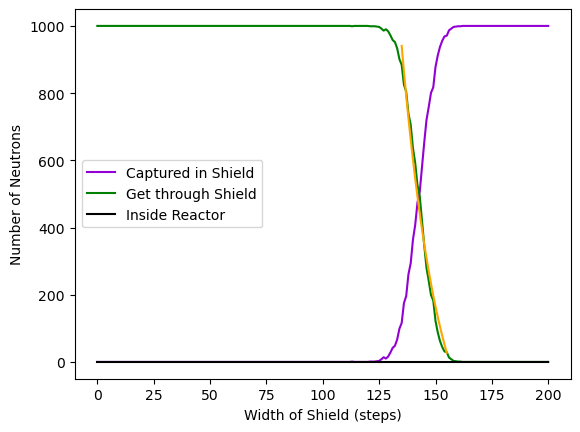

In [47]:
shield_array = np.array(shield_width) #converting the shield_width's list to an array that way logical conditions be applied
shield_mask = (shield_array >=135) & (shield_array <160) #only want to include the data points between 135 and 160 because this is where the curve starts to look like an exponential
array_len_x = np.array(len_x)
x_dat = shield_array[shield_mask] #applying the mask
y_dat= array_len_x[shield_mask]  #applying the mask

x = np.linspace(135, 155, 100) #only plot from x=135 to x=155
x_dat_err = 0 #no error in the x direction
y_dat_err = 0 #no error in the y direction

#fitting the exponential and printing out the best fit parameters of the exponential
a_exp, b_exp, c_exp, d_exp = mcFit4(exponential, x_dat, y_dat, y_dat_err, x_dat_err, p0=[0,0.19,30,0])
print("Exponential:", "a:{:.3e}".format(a_exp)+" "+"b:{:.3e}".format(b_exp)+" "+"c:{:.3e}".format(c_exp)+" "+"d:{:.3e}".format(d_exp))
#plotting the data and the best fit line
plot(shield_width,len_in_x, color ='darkviolet', label = 'Captured in Shield')
plot(shield_width,len_x, color ='green', label = "Get through Shield")
plot(shield_width,len_reactor_x, color ='k', label = "Inside Reactor")
legend()
plot(x, exponential(x, np.mean(a_exp), np.mean(b_exp), np.mean(c_exp), np.mean(d_exp)), color='orange')
xlabel("Width of Shield (steps)")
ylabel("Number of Neutrons")

#savefig("First_conditions.pdf")
show()


The following cell holds the calculations for the probabilities of the locations of the neutrons as a function of the shield's size. It prints out what probability each location has at each of the step sizes between 0 and 200 (with zero being the shield doesn't exist).

In [49]:
for i in range(0,201):
    print("At a shield width of"+" "+str(i)+" "+"steps:")
    print ("The probability of being outside the shield is:"+" "+ str(round((len_x[i]/1000)*100,3)))
    print ("The probability of being in the reactor is:"+" "+ str(round((len_reactor_x[i]/1000)*100,3)))
    print ("The probability of being trapped in the shield is:"+" "+ str(round((len_in_x[i]/1000)*100,3)))
    print("_________________________________________________________")

At a shield width of 0 steps:
The probability of being outside the shield is: 100.0
The probability of being in the reactor is: 0.0
The probability of being trapped in the shield is: 0.0
_________________________________________________________
At a shield width of 1 steps:
The probability of being outside the shield is: 100.0
The probability of being in the reactor is: 0.0
The probability of being trapped in the shield is: 0.0
_________________________________________________________
At a shield width of 2 steps:
The probability of being outside the shield is: 100.0
The probability of being in the reactor is: 0.0
The probability of being trapped in the shield is: 0.0
_________________________________________________________
At a shield width of 3 steps:
The probability of being outside the shield is: 100.0
The probability of being in the reactor is: 0.0
The probability of being trapped in the shield is: 0.0
_________________________________________________________
At a shield width of

In [50]:
#finding the exponential alpha value and its uncertainty
popt, pcov = opt.curve_fit(exponential, x_dat, y_dat, p0=[0,0.19,30,0])
print(popt[1])
print(pcov[1][1])

0.0599464776419802
7.17597937115756e-05


Second Trial Conditions: neutron energy as a normal distribution with a mean value of 100 steps and a standard deviation of 20 steps. 68% falls within 20 steps of the mean, 95% falls within 40 steps of the mean, and 99.7% fall within 60 steps

This is my code for determining the number of steps each neutron will take (the initial neutron energy)

In [7]:
random_number = random.randint(1,2) #pick a random number to decide whether 
#the neutron goes 100 steps or some number of steps based on the standard deviation

if random_number == 1:
    neutron_energy_init = 100 #inital energy is 100 units
else:
    number_of_steps = random.random() #select a random number between 0 and 1
    #less than 50 percent side of the normal distribution
    if number_of_steps <0.50 and number_of_steps >0.34: #the neutron will go one standard deviation from the mean
        neutron_energy_init = random.randint(80,99) #picks a random number to decide how many steps the neutron will go
    elif number_of_steps <0.34 and number_of_steps >0.135: #two standard deviations
        neutron_energy_init = random.randint(60,79) #choose a random number of steps
    elif number_of_steps <0.135 and number_of_steps >0.0235: #three standard deviations
        neutron_energy_init = random.randint(40,59) #choose a random number of steps
    elif number_of_steps <0.023: #four standard deviations
        neutron_energy_init = random.randint(0,39) #choose a random number
   
   #greater than 50 percent side of the normal distribution
    elif number_of_steps >0.50 and number_of_steps <0.84: #one standard deviation
        neutron_energy_init = random.randint(101,119)
    elif number_of_steps >0.84 and number_of_steps <0.975: #two standard deviations
        neutron_energy_init = random.randint(120,139)
    elif number_of_steps >0.975 and number_of_steps <0.9985: #three standard deviations
        neutron_energy_init = random.randint(141,159)
    elif number_of_steps >0.9985: #four standard deviations
        neutron_energy_init = random.randint(160,200)
    
print(neutron_energy_init)

1
100


I copied the above code determining the number of steps into my code that finds whether the neutron is in the reactor, in the shield or made it through the shield. 

In [51]:
#where 1=left,2=right, 3=forward,4=backward
shield_x_list = arange(0,201, 1) #still have width of the shield the same
#have all of the lists in which to store the lengths of the lists of neutrons
#at each of the locations
norm_len_x = []  
norm_len_reactor_x = []
norm_len_in_x = []
norm_shield_width = []
for i in shield_x_list:
    shield_x  = i #this is the starting width of the shield's size
    norm_shield_width.append(shield_x)
    #the lists to hold the neutrons
    norm_out_x = []
    norm_reactor_x = []
    norm_in_x = []
    
        
    for i in range(0,1000): # for each width we want 1000 trials
        x_1 = 0
        move = 1
        #this whole section of code is determining the neutron energy
        random_number = random.randint(1,2) #choose whether the neutron goes 100 steps or some standard deviations of steps
        if random_number == 1: #goes 100 steps
            neutron_energy_init = 100
        else:
            number_of_steps = random.random()
    #less than 50 percent side of the normal distribution
            if number_of_steps <0.50 and number_of_steps >0.34: #one standard deviation
                neutron_energy_init = random.randint(80,99)
            elif number_of_steps <0.34 and number_of_steps >0.135: #two standard deviations
                neutron_energy_init = random.randint(60,79)
            elif number_of_steps <0.135 and number_of_steps >0.0235: #three standard deviations
                neutron_energy_init = random.randint(40,59)
            elif number_of_steps <0.023: #four standard deviations
                neutron_energy_init = random.randint(0,39)
                
    #greater than 50 percent side of the normal distribution
            elif number_of_steps >0.50 and number_of_steps <0.84: #one standard deviation
                neutron_energy_init = random.randint(101,119)
            elif number_of_steps >0.84 and number_of_steps <0.975: #two standard deviations
                neutron_energy_init = random.randint(120,139)
            elif number_of_steps >0.975 and number_of_steps <0.9985: #three standard deviations
                neutron_energy_init = random.randint(141,159)
            elif number_of_steps >0.9985: #four standard deviations
                neutron_energy_init = random.randint(160,200)
        
        while neutron_energy_init >=0: #while the energy is greater than zero, keep running the random walk process
            if move == 1:
                direction_choice_move_1 = random.randint(1,4)
                if direction_choice_move_1 == 1:
                    y_1 += 1 #move left
                elif direction_choice_move_1 == 2:
                    y_1 -= 1 #move right
                elif direction_choice_move_1 == 3:
                    x_1 += 1 #move forward
                elif direction_choice_move_1 == 4:
                    x_1 -= 1 #move backward
                neutron_energy_init -=1
                move +=1
#second move only has choices 3=forward,1=left, or 2=right
            elif move >1:
                direction_choice_move_2 = random.choices([1,2,3], weights= [1,1,5], k=1)
                if direction_choice_move_2[0] == 1:
                    y_1 += 1 #move left
                elif direction_choice_move_2[0] == 2:
                    y_1 -= 1 #move right
                elif direction_choice_move_2[0] == 3:
                    x_1 += 1 #move forward
                neutron_energy_init -=1 #lose one unit of energy
        if x_1 <= 0:#still inside the reactor
            norm_reactor_x.append(x_1)
        if 0< x_1 and x_1 <= shield_x:#inside the shield
            norm_in_x.append(x_1)
        else:#outside the shield
            norm_out_x.append(x_1)
    
    norm_len_x.append(len(norm_out_x))
    norm_len_reactor_x.append(len(norm_reactor_x))
    norm_len_in_x.append(len(norm_in_x))


Exponential: a:2.764e+02 b:9.560e-02 c:7.297e+00 d:-1.570e+01


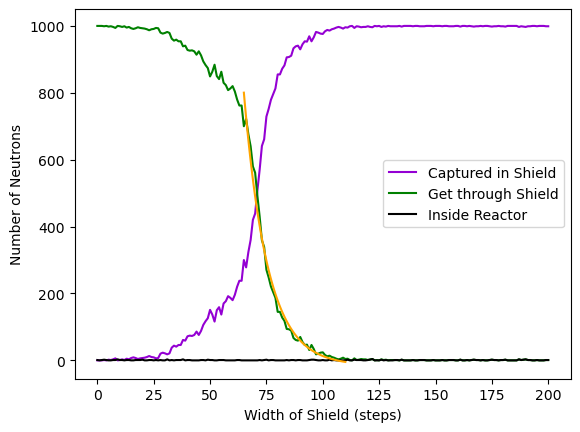

In [56]:
norm_shield_array = np.array(norm_shield_width)
norm_shield_mask = (norm_shield_array >=65) & (norm_shield_array <110) #masking to only include values in the range greater than 65 and less than 110
norm_array_len_x = np.array(norm_len_x)
norm_x_dat = norm_shield_array[norm_shield_mask] #masking the data
norm_y_dat= norm_array_len_x[norm_shield_mask]

norm_x = np.linspace(65, 110, 100)
norm_x_dat_err = 0 #no error in x direction
norm_y_dat_err = 0 #no error in the y direction
norm_a_exp, norm_b_exp, norm_c_exp, norm_d_exp = mcFit4(exponential, norm_x_dat, norm_y_dat, norm_y_dat_err, norm_x_dat_err, p0=[0,0,0,0])

print("Exponential:", "a:{:.3e}".format(norm_a_exp)+" "+"b:{:.3e}".format(norm_b_exp)+" "+"c:{:.3e}".format(norm_c_exp)+" "+"d:{:.3e}".format(norm_d_exp))
#plotting all of the data and best fit line
plot(norm_shield_width,norm_len_in_x, color ='darkviolet', label = 'Captured in Shield')
plot(norm_shield_width,norm_len_x, color ='green', label = "Get through Shield")
plot(norm_shield_width,norm_len_reactor_x, color ='k', label = "Inside Reactor")
legend()
plot(norm_x, exponential(norm_x, np.mean(norm_a_exp), np.mean(norm_b_exp), np.mean(norm_c_exp), np.mean(norm_d_exp)), color='orange')
xlabel("Width of Shield (steps)")
ylabel("Number of Neutrons")

savefig("Second_conditions.pdf")
show()

The code below has the probabilities for each of the locations for a neutron's energy described as a normal distribution

In [54]:
for i in range(0,201):
    print("At a shield width of"+" "+str(i)+" "+"steps:")
    print ("The probability of being outside the shield is:"+" "+ str(round((norm_len_x[i]/1000)*100,3)))
    print ("The probability of being in the reactor is:"+" "+ str(round((norm_len_reactor_x[i]/1000)*100,3)))
    print ("The probability of being trapped in the shield is:"+" "+ str(round((norm_len_in_x[i]/1000)*100,3)))
    print("_________________________________________________________")

At a shield width of 0 steps:
The probability of being outside the shield is: 100.0
The probability of being in the reactor is: 0.1
The probability of being trapped in the shield is: 0.0
_________________________________________________________
At a shield width of 1 steps:
The probability of being outside the shield is: 100.0
The probability of being in the reactor is: 0.0
The probability of being trapped in the shield is: 0.0
_________________________________________________________
At a shield width of 2 steps:
The probability of being outside the shield is: 100.0
The probability of being in the reactor is: 0.1
The probability of being trapped in the shield is: 0.0
_________________________________________________________
At a shield width of 3 steps:
The probability of being outside the shield is: 99.9
The probability of being in the reactor is: 0.2
The probability of being trapped in the shield is: 0.1
_________________________________________________________
At a shield width of 

Now, the exponent "alpha" of the best fit of the exponential can be determined for the normal distribution trial

In [55]:
norm_popt, norm_pcov = opt.curve_fit(exponential, norm_x_dat, norm_y_dat, p0=[0,0,0,0])
print(norm_popt[1])
print(norm_pcov[1][1])

0.09559990599314158
1.934870100847895e-05
